# Introduction to JumpStart - Object Detection

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). 

In this demo notebook, we demonstrate how to use the JumpStart API for Object Detection.  Object Detection refers to localizing objects in an image with a bounding box and predicting the classes of the objects. It can be used for counting objects, determining their exact locations and many more. It is applied to areas including security, surveillance, automated vehicle systems and machine inspection.

In this notebook, we demonstrate two use cases of object detection models:

* How to use pre-trained models trained on COCO dataset to do object detection.
* How to use JumpStart transfer learning algorithm to train an Object Detection model on a custom dataset. 

---

1. [Set Up](#1.-Set-Up)
2. [Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model)
    * [Select a pre-trained model for inference](#2.1.-Select-a-pre-trained-model-for-inference)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.2.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Download an example image for inference](#2.3.-Download-an-example-image-for-inference)
    * [Query endpoint and parse response](#2.4.-Query-endpoint-and-parse-response)
    * [Display model predictions](#2.5.-Display-model-predictions)
    * [Clean up the endpoint](#2.6.-Clean-up-the-endpoint)


3. [Fine-tune the pre-trained model on a custom dataset](#3.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#3.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#3.4.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.5.-Deploy-and-run-inference-on-the-fine-tuned-model)


Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

---

In [ ]:
!pip install sagemaker ipywidgets --upgrade --quiet

### Permissions and environment variables

---
To train and host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. 
***

### 2.1. Select a pre-trained model for inference

***
Here, we download jumpstart model_manifest file from the jumpstart s3 bucket, filter-out all the Object Detection models and select a model for inference.
***

In [3]:
from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(
    f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Object Detection models from the manifest list.
od_models = []
for model in model_list:
    model_id = model["model_id"]
    if ("-od-" in model_id or "-od1-" in model_id) and model_id not in od_models:
        od_models.append(model_id)

print(f"Number of models available for inference: {len(od_models)}")

# display the model-ids in a dropdown to select a model for inference.
infer_model_dropdown = Dropdown(
    options=od_models,
    value="pytorch-od-nvidia-ssd",
    description="Select a model:",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

Number of models available for inference: 70


#### Chose a model for Inference

In [4]:
display(infer_model_dropdown)

Dropdown(description='Select a model:', index=17, layout=Layout(width='max-content'), options=('mxnet-od-faste…

### 2.2. Retrieve JumpStart Artifacts & Deploy an Endpoint

***
We retrieve the `deploy_image_uri`, `deploy_source_uri`, and `base_model_uri` for the pre-trained model. To host the pre-trained base-model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.
***

In [9]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

# model_version="*" fetches the latest version of the model
infer_model_id, infer_model_version = infer_model_dropdown.value, "*"


endpoint_name = name_from_base(f"jumpstart-example-infer-{infer_model_id}")

inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=infer_model_id,
    model_version=infer_model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, script_scope="inference"
)


# Retrieve the base model uri
base_model_uri = model_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

-----!

### 2.3. Download an example image for inference
---
We download an example image from the JumpStart assets S3 bucket.

---

In [10]:
jumpstart_assets_s3_bucket = f"jumpstart-cache-prod-{aws_region}"
Naxos_Taverna_key_prefix = "pytorch-metadata/assets"
Naxos_Taverna = "Naxos_Taverna.jpg"

boto3.client("s3").download_file(
    jumpstart_assets_s3_bucket, f"{Naxos_Taverna_key_prefix}/{Naxos_Taverna}", Naxos_Taverna
)

### 2.4. Query endpoint and parse response

---
Input to the endpoint is a single image in binary format. Response of the endpoint is a set of bounding boxes as well as class names and scores for the bounding boxes. JumpStart allows the flexibility in the number of bounding boxes returned. Below, we show to predict two bounding boxes per image by appending `;n_predictions=2` to `Accept`. To predict xx boxes, one can change it to `;n_predictions=xx` or to get all the predicted boxes, one can remove `;n_predictions=2`.

---

In [11]:
import json


def query(model_predictor, image_file_name):

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose;n_predictions=2",
        },
    )
    return query_response


def parse_response(query_response):
    model_predictions = json.loads(query_response)
    normalized_boxes, classes, scores, labels = (
        model_predictions["normalized_boxes"],
        model_predictions["classes"],
        model_predictions["scores"],
        model_predictions["labels"],
    )
    # Substitute the classes index with the classes name
    class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, class_names, scores

In [12]:
query_response = query(base_model_predictor, Naxos_Taverna)

normalized_boxes, classes_names, confidences = parse_response(query_response)

### 2.5. Display model predictions
---
Next, we display the bounding boxes overlaid on the original image.

---

In [17]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
import numpy as np


def display_predictions(img_jpg, normalized_boxes, classes_names, confidences):
    colors = list(ImageColor.colormap.values())
    image_np = np.array(Image.open(img_jpg))
    plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.imshow(image_np)

    for idx in range(len(normalized_boxes)):
        left, bot, right, top = normalized_boxes[idx]
        x, w = [val * image_np.shape[1] for val in [left, right - left]]
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
        color = colors[hash(classes_names[idx]) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x,
            y,
            "{} {:.0f}%".format(classes_names[idx], confidences[idx] * 100),
            bbox=dict(facecolor="white", alpha=0.5),
        )

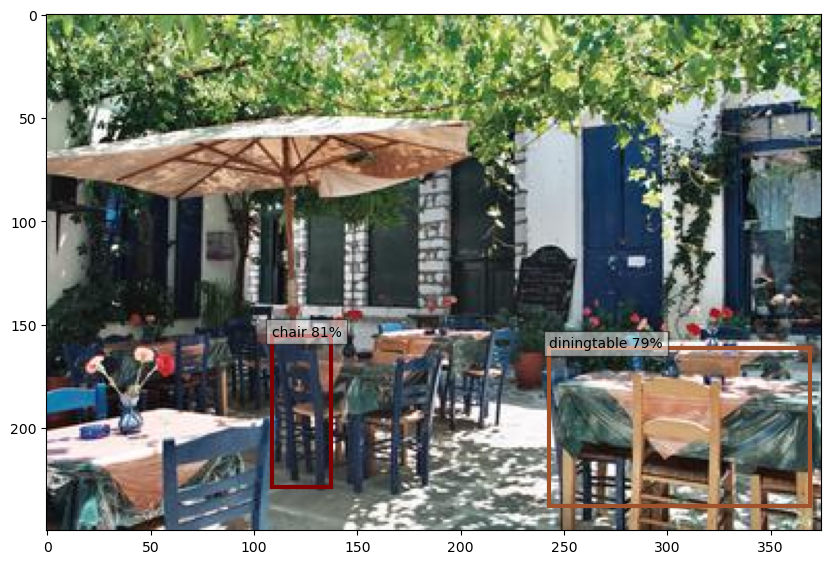

In [18]:
display_predictions(Naxos_Taverna, normalized_boxes, classes_names, confidences)

### 2.6. Clean up the endpoint

In [ ]:
# Delete the SageMaker endpoint
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()

## 3. Fine-tune the pre-trained model on a custom dataset

---
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes. 

Transfer learning algorithm removes the object detection head of the pre-trained model and attaches a new randomly initialized head with number of classes same as the custom dataset. The fine-tuning step fine-tunes the last layer parameters while keeping the parameters of the rest of the model frozen, and returns the fine-tuned model. The objective during finetuning is to minimize box prediction error on the input data. 

Input to the algorithm must be a directory with sub-directoriey images and a file annotations.json. The input directory should look like below if the training data contains two images. The names of .png files
can be anything. 

    input_directory
        |--images
            |--abc.png
            |--def.png
        |--annotations.json
            
 
The annotations.json file should have information for bounding_boxes and their class labels. It should have a 
dictionary with keys "images" and "annotations". Value for the "images" key should be a list of entries, 
one for each image of the form {"file_name": image_name, "height": height, "width": width, "id": image_id}. Value of the 'annotations' key should be a list of entries, one for each bounding box of the form {"image_id": image_id, "bbox": \[xmin, ymin, xmax, ymax\], "category_id": bbox_label}.

We provide pennfudanped dataset as a default dataset for fine-tuning the model.
PennFudanPed comprises images of pedestrians. The dataset has been downloaded from [here](https://www.cis.upenn.edu/~jshi/ped_html/#pub1). 

Citation:
<sub><sup>
@ONLINE {pennfudanped,
author = "Liming Wang1, Jianbo Shi2, Gang Song2, and I-fan Shen1",
title = "Penn-Fudan Database for Pedestrian Detection and Segmentation",
year = "2007",
url = "https://www.cis.upenn.edu/~jshi/ped_html/" }
</sup></sub>

### 3.1. Retrieve Training Artifacts

Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [ ]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "mxnet-od-ssd-512-vgg16-atrous-coco",  # "pytorch-od1-fasterrcnn-resnet50-fpn"
    "*",
    "training",
)
training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### 3.2. Set Training parameters

---
Now that we are done with all the set up that is needed, we are ready to train our Object Detection model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training. We defined the training instance type above to fetch the correct train_image_uri. 

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [ ]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/PennFudanPed_COCO_format/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-od-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [ ]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["epochs"] = "10"
print(hyperparameters)

### 3.3. Train with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) object to interact with Amazon SageMaker hyperparameter tuning APIs.
***

In [ ]:
from sagemaker.tuner import ContinuousParameter

# Use AMT for tuning and selecting the best model
use_amt = True

# Define objective metric per framework, based on which the best model will be selected.
metric_definitions_per_model = {
    "mxnet": {
        "metrics": [{"Name": "val_cross_entropy", "Regex": "Val_CrossEntropy=([0-9\\.]+)"}],
        "type": "Minimize",
    },
    "pytorch": {
        "metrics": [{"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"}],
        "type": "Minimize",
    },
}

# You can select from the hyperparameters supported by the model, and configure ranges of values to be searched for training the optimal model.(https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html)
hyperparameter_ranges = {
    "adam-learning-rate": ContinuousParameter(0.0001, 0.1, scaling_type="Logarithmic")
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2

### 3.4. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes less than 10 mins on the default dataset.

---

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
od_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

if use_amt:
    metric_definitions = next(
        value
        for key, value in metric_definitions_per_model.items()
        if train_model_id.startswith(key)
    )

    hp_tuner = HyperparameterTuner(
        od_estimator,
        metric_definitions["metrics"][0]["Name"],
        hyperparameter_ranges,
        metric_definitions["metrics"],
        max_jobs=max_jobs,
        max_parallel_jobs=max_parallel_jobs,
        objective_type=metric_definitions["type"],
        base_tuning_job_name=training_job_name,
    )

    # Launch a SageMaker Tuning job to search for the best hyperparameters
    hp_tuner.fit({"training": training_dataset_s3_path})
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    od_estimator.fit({"training": training_dataset_s3_path}, logs=True)

### 3.5. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model). We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

---

In [ ]:
inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (hp_tuner if use_amt else od_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

---
Next, we download an example pedestrian image from the S3 bucket for inference.

---

In [ ]:
jumpstart_assets_bucket = f"jumpstart-cache-prod-{aws_region}"
pedestrian_image_key = "training-datasets/PennFudanPed_COCO_format/images"
pedestrian_image_file_name = "FudanPed00001.png"

boto3.client("s3").download_file(
    jumpstart_assets_bucket,
    f"{pedestrian_image_key}/{pedestrian_image_file_name}",
    pedestrian_image_file_name,
)

---
Next, we query the finetuned model, parse the response and display the predictions. Functions for these are implemented in sections [2.4. Query endpoint and parse response](#2.4.-Query-endpoint-and-parse-response) and [2.5. Display model predictions](#2.5.-Display-model-predictions)

---

In [ ]:
query_response = query(finetuned_predictor, pedestrian_image_file_name)

normalized_boxes, classes_names, confidences = parse_response(query_response)
display_predictions(pedestrian_image_file_name, normalized_boxes, classes_names, confidences)

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()